This notebook contains my implementation of the Convolutional LSTM cells, and a toy problem of counting the number of "1"s in a binary string where the input is in the form of images containing "0" or "1".

Note: for this simple example there is only 1 image for each of the two values so we are not fully utilizing the convolutional aspect of the network, but it acts as a proof of concept that the implementation works.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
from functools import reduce

%matplotlib inline

In [2]:
import numpy as np
from random import shuffle
from scipy.misc import imread

img0 = np.reshape(1.0 - imread('./binary_pics/0.png', flatten=True)/255, newshape=(28, 28, 1,))
img1 = np.reshape(1.0 - imread('./binary_pics/1.png', flatten=True)/255, newshape=(28, 28, 1,))

train_input = ['{0:020b}'.format(i) for i in range(2**20)]
shuffle(train_input)
#train_input = train_input[:101000]
train_output = np.zeros((len(train_input), 21))
train_output[range(len(train_output)), [reduce(lambda x, y: int(x) + int(y), i) for i in train_input]] = 1
train_input = [map(int,i) for i in train_input]
ti = []
for idx, train_instance in enumerate(train_input):
    temp_arr = []
    for j in train_instance:
        temp_arr.append(img0 if j == 0 else img1)
    ti.append(temp_arr)
train_input = np.array(ti)

In [3]:
NUM_EXAMPLES = 1000
train_X = train_input[:NUM_EXAMPLES]
train_y = train_output[:NUM_EXAMPLES]
test_X = train_input[NUM_EXAMPLES:]
test_y = train_output[NUM_EXAMPLES:]

In [10]:
seed = 42

# Define required layers
def conv_relu(inputs, kernel_shape, name, add_bias=True, padding='SAME', data_format='NHWC'):
    with tf.variable_scope(name):
        weights = tf.get_variable(dtype=tf.float32, shape=kernel_shape, initializer=tf.contrib.layers.xavier_initializer(), name='weights')
        x = tf.nn.conv2d(inputs, filter=weights, strides=(1,1,1,1,), padding=padding, data_format=data_format)
        if add_bias:
            biases = tf.get_variable(dtype=tf.float32, shape=(1, 1, 1, kernel_shape[-1],), initializer=tf.constant_initializer(0.0), name='biases')
            x = x + biases
        #return tf.nn.relu(x)
        return tf.maximum(0.02 * x, x)
    
def max_pool(input, data_format='NHWC'):
    return tf.nn.max_pool(input, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1), padding='SAME', data_format=data_format)

In [11]:
class MyConvLSTMCell(tf.contrib.rnn.RNNCell):
    def __init__(self, input_shape, kernel_shape, n_filters, forget_bias=1.0):
        super(MyConvLSTMCell, self).__init__()
        self._size = tf.TensorShape([input_shape, input_shape, n_filters])
        self._kernel_shape = kernel_shape
        self._n_filters = n_filters
        self._forget_bias = forget_bias
    
    @property
    def state_size(self):
        return tf.nn.rnn_cell.LSTMStateTuple(self._size, self._size)
    
    @property
    def output_size(self):
        return self._size
    
    def call(self, inputs, state):
        c, h = state
        
        n_channels = inputs.shape[3] + self._n_filters
        n_filters = 4 * self._n_filters
        concat = conv_relu(tf.concat(values=[inputs, h], axis=3), (self._kernel_shape, self._kernel_shape, n_channels, n_filters), name='LSTMConvRelu')
        i, f, o, c_in = tf.split(value=concat, num_or_size_splits=4, axis=3)
        i, f, o, c_in = tf.sigmoid(i), tf.sigmoid(f + self._forget_bias), tf.sigmoid(o), tf.tanh(c_in)
        c_new = c * f + i * c_in
        h_new = o * tf.tanh(c_new)

        state_new = tf.nn.rnn_cell.LSTMStateTuple(c_new, h_new)
        return h_new, state_new

In [12]:
tf.reset_default_graph()
tf.set_random_seed(seed)

X = tf.placeholder(dtype=tf.float32, shape=(None, 20, 28, 28, 1,))
y = tf.placeholder(dtype=tf.int32, shape=(None, 21,))

with tf.name_scope('Network'):
    # Reshape
    X_preprocess = tf.reshape(X, shape=(-1, 28, 28, 1))
    # Conv1
    X_preprocess = conv_relu(X_preprocess, kernel_shape=(3, 3, 1, 10), name='ConvRelu1')
    # Maxpool1
    X_preprocess = max_pool(X_preprocess)
    # Conv2
    X_preprocess = conv_relu(X_preprocess, kernel_shape=(3, 3, 10, 20), name='ConvRelu2')
    # Maxpool2
    X_preprocess = max_pool(X_preprocess)
    # Reshape back
    X_preprocess = tf.reshape(X_preprocess, shape=(-1, 20, 7, 7, 20,))

    #LSTM (Conv2)
    cell = MyConvLSTMCell(7, 3, 30)
    val, state = tf.nn.dynamic_rnn(cell, X_preprocess, dtype=tf.float32)

    # Switch dimensions to get time dimension in beginning
    val = tf.transpose(val, [1, 0, 2, 3, 4])
    # Gather the outputs of the last cell only containing the count of all ones
    last = tf.gather(val, 19)

    # Conv3
    X_postprocess = conv_relu(last, kernel_shape=(7, 7, 30, 1000), padding='VALID', name='ConvRelu3')
    # Conv4
    X_postprocess = conv_relu(X_postprocess, kernel_shape=(1, 1, 1000, 400), name='ConvRelu4')
    # Conv5
    X_postprocess = conv_relu(X_postprocess, kernel_shape=(1, 1, 400, 21), name='ConvRelu5')
    logits = tf.reshape(X_postprocess, shape=(-1, 21,))

with tf.name_scope('loss'):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))

with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-4)
    train_op = optimizer.minimize(loss)

with tf.name_scope('eval'):
    output = tf.argmax(logits, 1)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(output, tf.argmax(y, 1)), tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [13]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
num_epochs = 100
batch_size = 200

for i in range(num_epochs):
    for j in range(NUM_EXAMPLES//batch_size):
        sess.run(train_op, feed_dict={X: train_X[j*batch_size:(j+1)*batch_size], y: train_y[j*batch_size:(j+1)*batch_size]})
    acc, l = sess.run([accuracy, loss], feed_dict={X: train_X, y: train_y})
    print('%d: accuracy: %f, %f' % (i, acc, l))

print('Final training accuracy: ', sess.run([accuracy, loss], feed_dict={X: train_X, y: train_y}))
testing_accuracies = []
for i in range(100):
    testing_accuracies.append(accuracy.eval(feed_dict={X: test_X[i*1000:(i+1)*1000], y: test_y[i*1000:(i+1)*1000]}))
print('Final testing accuracy: ' , np.mean(testing_accuracies))
saver.save(sess, './counting-conv-lstm.ckpt')

0: accuracy: 0.162000, 2.979653
1: accuracy: 0.162000, 2.870096
2: accuracy: 0.162000, 2.706068
3: accuracy: 0.190000, 2.590760
4: accuracy: 0.158000, 2.580671
5: accuracy: 0.155000, 2.553548
6: accuracy: 0.166000, 2.554590
7: accuracy: 0.196000, 2.539707
8: accuracy: 0.215000, 2.528972
9: accuracy: 0.216000, 2.517405
10: accuracy: 0.222000, 2.476867
11: accuracy: 0.209000, 2.360111
12: accuracy: 0.231000, 2.227421
13: accuracy: 0.250000, 2.169732
14: accuracy: 0.274000, 2.102192
15: accuracy: 0.339000, 1.997261
16: accuracy: 0.444000, 1.836992
17: accuracy: 0.453000, 1.666197
18: accuracy: 0.486000, 1.552577
19: accuracy: 0.585000, 1.453385
20: accuracy: 0.709000, 1.362246
21: accuracy: 0.765000, 1.277719
22: accuracy: 0.795000, 1.199731
23: accuracy: 0.813000, 1.122648
24: accuracy: 0.845000, 1.046429
25: accuracy: 0.869000, 0.966905
26: accuracy: 0.891000, 0.894784
27: accuracy: 0.896000, 0.832809
28: accuracy: 0.904000, 0.773542
29: accuracy: 0.911000, 0.718065
30: accuracy: 0.9140

'./counting-conv-lstm.ckpt'

In [84]:
train_input = ['{0:020b}'.format(i) for i in range(2**20)]
shuffle(train_input)
train_output = np.zeros((len(train_input), 21))
train_output[range(len(train_output)), [reduce(lambda x, y: int(x) + int(y), i) for i in train_input]] = 1
train_input = [map(int,i) for i in train_input]
testing_accuracies = []
for i in range(len(train_input) / 1000):
    ti = []
    for idx, train_instance in enumerate(train_input[i*1000:(i+1)*1000]):
        temp_arr = []
        for j in train_instance:
            temp_arr.append(img0 if j == 0 else img1)
        ti.append(temp_arr)
    test_X = np.array(ti)
    test_y = train_output[i*1000:(i+1)*1000]
    testing_accuracies.append(accuracy.eval(feed_dict={X: test_X, y: test_y}))
    if i % 100 == 0:
        print(i)
print('Final testing accuracy: ' , np.mean(testing_accuracies))

0
100
200
300
400
500
600
700
800
900
1000
('Final testing accuracy: ', 0.99663562)


In [66]:
def prep(code):
    input = [[]]
    count = [0]
    for i in code:
        input[0].append(img0 if i == '0' else img1)
        count[0] += int(i)
    return np.array(input), count

In [67]:
def pred(code):
    inputs, target = prep(code)
    f, axs = plt.subplots(1, 20, figsize=(15, 15))
    for i in range(len(code)):
        axs[i].imshow(inputs[0, i].reshape((28, 28)))
        axs[i].axis('off')
    print('Real: ', target)
    print('Predicted: ', np.argmax(logits.eval(feed_dict={X: inputs}), 1)[0])
    return inputs

('Real: ', [15])
('Predicted: ', 15)


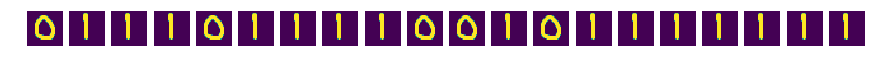

In [83]:
pred('01110111100101111111')

In [86]:
sess.close()